<a href="https://colab.research.google.com/github/aai510-group1/project/blob/main/Final_Project_Section3_Team_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project Section3 -Team 1

Team Members:
- Jon Augustin
- Dina Shalaby
- Paul Parks


## Includes

In [ ]:
!apt-get install -qqq --no-install-recommends graphviz libgraphviz-dev

# USE uv FOR FASTER PIP INSTALLS
%pip install --quiet --progress-bar=off uv

# INSTALL DEPENDENCIES
!uv pip uninstall --system --quiet bokeh mkl
!uv pip install --system --quiet --upgrade pip
!uv pip install --system --quiet --upgrade black[jupyter] bokeh datasets isort pygraphviz setuptools wheel
!uv pip install --system --quiet autogluon numpy==1.24.4 shap

In [ ]:
# @title Create a Folder in Google Drive and Enable Top-Level Access in the File Browser { display-mode: "form" }
def setup_drive_folder(google_drive_folder):
    import contextlib, google.colab, os, pathlib
    if not google_drive_folder:
        google_drive_folder = "temp"
    with contextlib.redirect_stdout(open(os.devnull, 'w')):
        google.colab.drive.mount("/content/drive", force_remount=True)
    drive_path = pathlib.Path("/content/drive/MyDrive")
    colab_notebooks_path = drive_path / "Colab Notebooks"
    project_path = colab_notebooks_path / google_drive_folder
    project_path.mkdir(parents=True, exist_ok=True)
    shortcut = pathlib.Path(f"/content/{google_drive_folder}")
    shortcut.parent.mkdir(parents=True, exist_ok=True)
    if not shortcut.exists():
        shortcut.symlink_to(project_path)
    print(f"SHORTCUT: {shortcut} --> {project_path}")
    return str(shortcut)

google_drive_folder = "aai510-group1"  # @param { type: "string" }
SHORTCUT = setup_drive_folder(google_drive_folder)

SHORTCUT: /content/aai510-group1 --> /content/drive/MyDrive/Colab Notebooks/aai510-group1


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

## Dataset


In [ ]:
# LOAD MERGED TELCO CUSTOMER DATASET
from datasets import load_dataset
dataset = load_dataset('aai510-group1/telco-customer-churn', token=False)

# CONVERT DATASETS TO PANDAS DATAFRAMES
df_train = dataset['train'].to_pandas()
df_test = dataset['test'].to_pandas()
df_val = dataset['validation'].to_pandas()

df = pd.concat([df_train, df_test, df_val], ignore_index=True)

Generating train split:   0%|          | 0/4225 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1409 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1409 [00:00<?, ? examples/s]

In [ ]:
df

,Age,Avg Monthly GB Download,Avg Monthly Long Distance Charges,Churn,Churn Category,Churn Reason,Churn Score,City,CLTV,Contract,...,Streaming TV,Tenure in Months,Total Charges,Total Extra Data Charges,Total Long Distance Charges,Total Refunds,Total Revenue,Under 30,Unlimited Data,Zip Code
0,72,4,19.44,0,None,None,51,San Mateo,4849,Two Year,...,0,25,2191.15,0,486.00,0.0,2677.15,0,1,94403
1,27,59,45.62,0,None,None,27,Sutter Creek,3715,Month-to-Month,...,1,35,3418.20,0,1596.70,0.0,5014.90,1,1,95685
2,59,0,16.07,0,None,None,59,Santa Cruz,5092,Month-to-Month,...,0,46,851.20,0,739.22,0.0,1590.42,0,0,95064
3,25,27,0.00,0,None,None,49,Brea,2068,One Year,...,0,27,1246.40,30,0.00,0.0,1276.40,1,0,92823
4,31,21,17.22,1,Dissatisfaction,Network reliability,88,San Jose,4026,One Year,...,0,58,3563.80,0,998.76,0.0,4562.56,0,1,95117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,36,25,1.48,0,None,None,20,Bonsall,2385,Month-to-Month,...,1,10,638.95,90,14.80,0.0,743.75,0,0,92003
7039,25,58,6.23,0,None,None,78,El Sobrante,4090,Two Year,...,1,71,5924.40,0,442.33,0.0,6366.73,1,1,94803
7040,42,29,32.78,0,None,None,52,Navarro,3655,Month-to-Month,...,1,40,4108.15,0,1311.20,0.0,5419.35,0,1,95463
7041,44,3,18.38,1,Dissatisfaction,Poor expertise of phone support,76,Hathaway Pines,2850,Month-to-Month,...,0,12,858.60,0,220.56,0.0,1079.16,0,1,95233


Drop target and leakage variables

In [ ]:
# drop customer ID , Count, Country , State since they are not relevant to the analysis. All in US, CA
# df.drop(columns=['Customer ID','Country','State'], inplace=True)
# drop variables that are leaking the Target variable
df.drop(columns=['Churn Score','Churn Reason','Churn Category','Customer Status'], inplace=True)

Encoding

In [ ]:
# find non-numerical features and convert to numerical features
# Find non-numerical features
non_numerical_features = df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate through each non-numerical feature and perform label encoding
for feature in non_numerical_features:
    df[feature] = label_encoder.fit_transform(df[feature])


# Display the first few rows after label encoding
print("First 5 rows after label encoding:")
print(df.head())

First 5 rows after label encoding:
   Age  Avg Monthly GB Download  Avg Monthly Long Distance Charges  Churn  \
0   72                        4                              19.44      0   
1   27                       59                              45.62      0   
2   59                        0                              16.07      0   
3   25                       27                               0.00      0   
4   31                       21                              17.22      1   

   City  CLTV  Contract  Country  Customer ID  Dependents  ...  Streaming TV  \
0   873  4849         2        0         3157           0  ...             0   
1   976  3715         0        0         3766           0  ...             1   
2   887  5092         0        0         3887           0  ...             0   
3   109  2068         1        0         1508           0  ...             0   
4   863  4026         1        0          253           0  ...             0   

   Tenure in Months  

## Exploratory Data Analysis

Statistics:

In [ ]:
# Summary statistics
print("Summary statistics:")
print(df.describe())

Summary statistics:
               Age  Avg Monthly GB Download  \
count  7043.000000              7043.000000   
mean     46.509726                20.515405   
std      16.750352                20.418940   
min      19.000000                 0.000000   
25%      32.000000                 3.000000   
50%      46.000000                17.000000   
75%      60.000000                27.000000   
max      80.000000                85.000000   

       Avg Monthly Long Distance Charges        Churn         City  \
count                        7043.000000  7043.000000  7043.000000   
mean                           22.958954     0.265370   588.042879   
std                            15.448113     0.441561   307.797647   
min                             0.000000     0.000000     0.000000   
25%                             9.210000     0.000000   331.000000   
50%                            22.890000     0.000000   604.000000   
75%                            36.395000     1.000000   854.000000

Check for missing values

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values:")
print(missing_values)


Missing values:
Age                                  0
Avg Monthly GB Download              0
Avg Monthly Long Distance Charges    0
Churn                                0
City                                 0
CLTV                                 0
Contract                             0
Country                              0
Customer ID                          0
Dependents                           0
Device Protection Plan               0
Gender                               0
Internet Service                     0
Internet Type                        0
Lat Long                             0
Latitude                             0
Longitude                            0
Married                              0
Monthly Charge                       0
Multiple Lines                       0
Number of Dependents                 0
Number of Referrals                  0
Offer                                0
Online Backup                        0
Online Security                      0
Paperles

Correlation heatmap

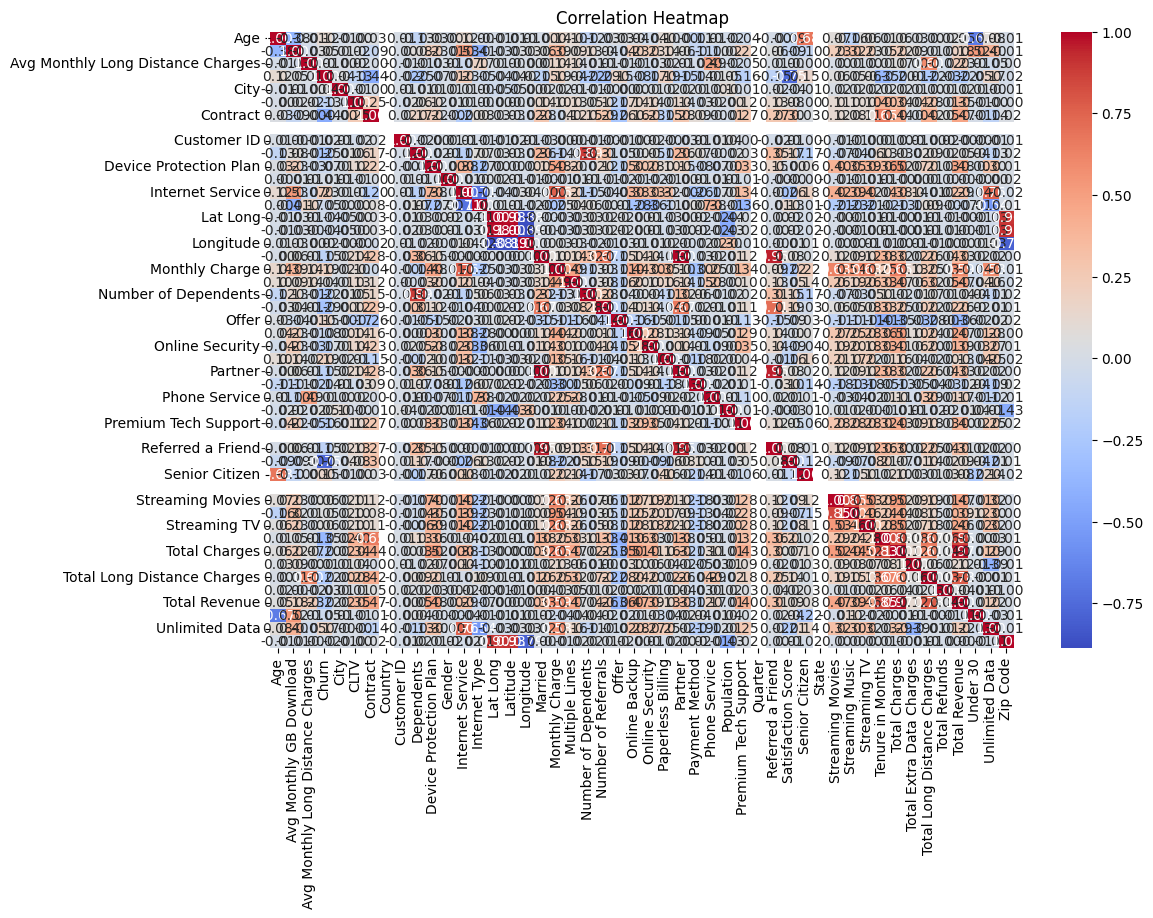

In [ ]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Distribution of numerical features

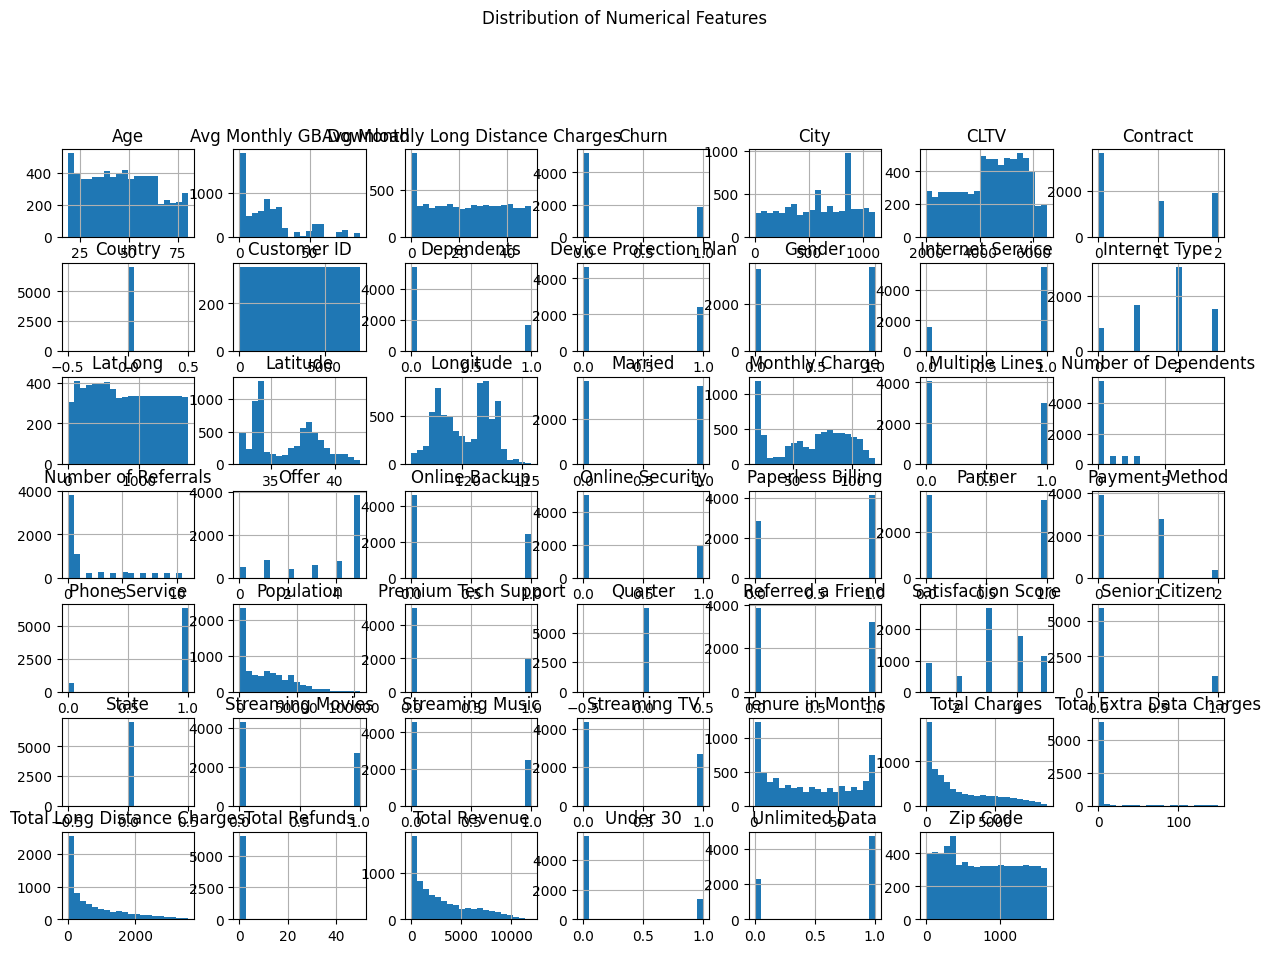

In [ ]:
# Distribution of numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
df[numerical_features].hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Features', x=0.5, y=1.02, ha='center', fontsize='large')
plt.show()

View some of the interesting feature distributions

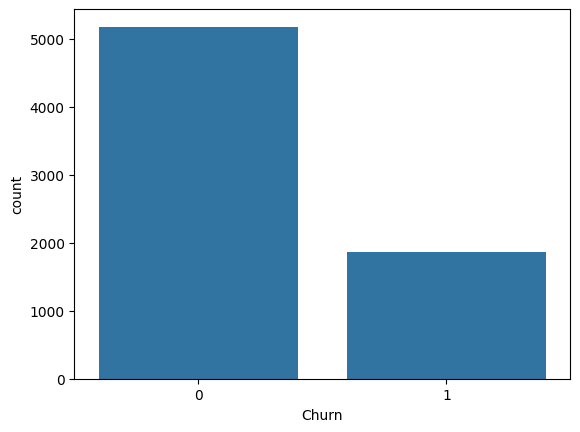

In [ ]:
sns.countplot(x='Churn', data=df)
plt.show()

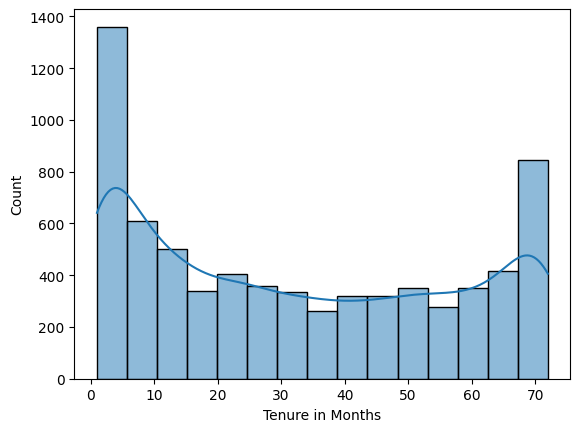

In [ ]:
sns.histplot(df['Tenure in Months'], kde=True)
plt.show()

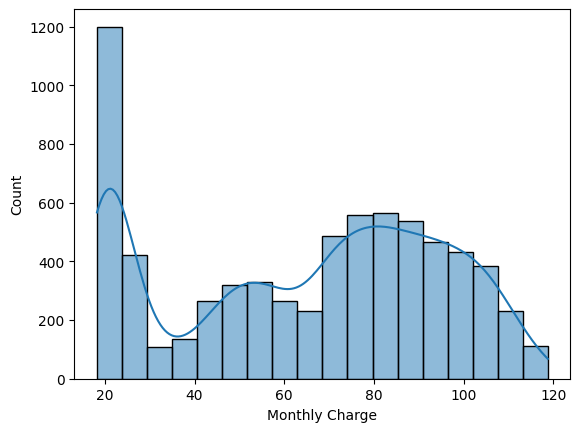

In [ ]:
sns.histplot(df['Monthly Charge'], kde=True)
plt.show()

# Features

Minimal dataset cleaning and feature engineering was needed with this dataset. We were able preprocessing the seperated .csv's into 1 .csv that is used in this notebook. Below we will detail the highly correlated features realted to Churn.

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Extract the correlation values for the 'Churn' column
churn_correlation = correlation_matrix["Churn"].drop("Churn")

# Sort the correlation values
churn_correlation_sorted = churn_correlation.abs().sort_values(ascending=False)

# Display the sorted correlation values
print("Features most highly correlated with 'Churn':")
print(churn_correlation_sorted)

# If you want to see the actual correlation values along with their signs
print("\nActual correlation values with 'Churn':")
print(churn_correlation.loc[churn_correlation_sorted.index])


Features most highly correlated with 'Churn':
Satisfaction Score                   0.754649
Contract                             0.435398
Tenure in Months                     0.352861
Number of Referrals                  0.286540
Dependents                           0.248542
Internet Service                     0.227890
Total Long Distance Charges          0.223756
Total Revenue                        0.223003
Number of Dependents                 0.218780
Total Charges                        0.198546
Monthly Charge                       0.193356
Paperless Billing                    0.191825
Online Security                      0.171226
Unlimited Data                       0.166545
Premium Tech Support                 0.164674
Offer                                0.151112
Senior Citizen                       0.150889
Partner                              0.150448
Married                              0.150448
Referred a Friend                    0.149122
Payment Method                    

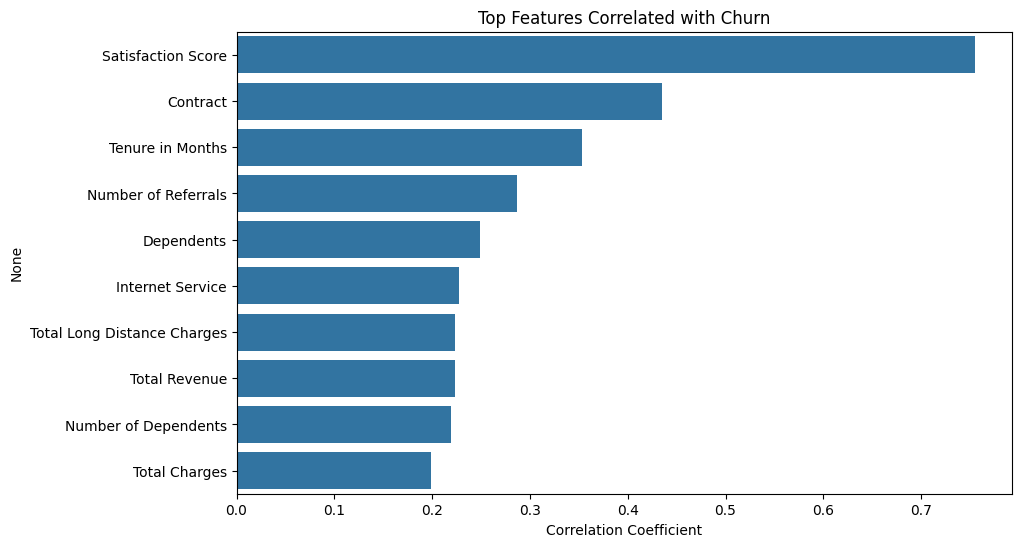

In [ ]:
# Plot the top correlated features
top_features = churn_correlation_sorted.index[:10]  # You can choose the top N features
plt.figure(figsize=(10, 6))
sns.barplot(x=churn_correlation_sorted[top_features], y=top_features)
plt.title('Top Features Correlated with Churn')
plt.xlabel('Correlation Coefficient')
plt.show()

# Baseline Model

## Setup testing and training data

In [ ]:
# Split the data into features (X) and target variable (y)
X = df.drop(columns=['Churn'])
y = df['Churn']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Create a helper function for training and evaluation

In [ ]:
def fit_predict_evaluate(model, X_train, y_train, X_test, y_test):
    # Fit the model
    model.fit(X_train, y_train)

    # Predict the target vector
    dt_y_pred = model.predict(X_test)

    # Evaluate Decision Tree model
    dt_accuracy = accuracy_score(y_test, dt_y_pred)
    dt_precision = precision_score(y_test, dt_y_pred)
    dt_recall = recall_score(y_test, dt_y_pred)
    dt_f1 = f1_score(y_test, dt_y_pred)
    dt_conf_matrix = confusion_matrix(y_test, dt_y_pred)
    dt_roc_auc = roc_auc_score(y_test, dt_y_pred)
    print(f"Accuracy: {dt_accuracy}")
    print(f"Precision: {dt_precision}")
    print(f"Recall: {dt_recall}")
    print(f"F1 Score: {dt_f1}")
    print(f"Confusion Matrix:{dt_conf_matrix}")
    print(f'AUC: {dt_roc_auc }')
    print(dt_conf_matrix)

## Create a DecisionTreeClassifier to gather baseline metrics

In [ ]:
# Baseline Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)

print("Baseline Decision Tree Model:")
fit_predict_evaluate(dt_model, X_train, y_train, X_test, y_test)

Baseline Decision Tree Model:
Accuracy: 0.9559971611071683
Precision: 0.9162303664921466
Recall: 0.9210526315789473
F1 Score: 0.9186351706036745
Confusion Matrix:[[997  32]
 [ 30 350]]
AUC: 0.944977239015907
[[997  32]
 [ 30 350]]


## XGBoost

In [ ]:
xgb_model = XGBClassifier()

print("XGBoost Classifier:")
fit_predict_evaluate(xgb_model, X_train, y_train, X_test, y_test)

XGBoost Classifier:
Accuracy: 0.9616749467707594
Precision: 0.9527777777777777
Recall: 0.9026315789473685
F1 Score: 0.927027027027027
Confusion Matrix:[[1012   17]
 [  37  343]]
AUC: 0.9430553424377269
[[1012   17]
 [  37  343]]


## Hyperparam to optimize Xgboost

In [ ]:
 #Define parameter grid for Grid Search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

# Initialize XGBoost classifier
xgb_model = XGBClassifier()

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Predict using the best model
best_xgb_model = grid_search.best_estimator_

print("Best XGBoost Model:")
fit_predict_evaluate(best_xgb_model, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Score: 0.9620159779102002
Best XGBoost Model:
Accuracy: 0.9623846699787083
Precision: 0.9504132231404959
Recall: 0.9078947368421053
F1 Score: 0.9286675639300135
Confusion Matrix:[[1011   18]
 [  35  345]]
AUC: 0.9452010127359214
[[1011   18]
 [  35  345]]


## Predicting using Deep Neural Networks

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the deep neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model on the test set
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)


# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Deep Neural Network Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

45/45 [==============================] - 0s 2ms/step
Deep Neural Network Metrics:
Accuracy: 0.9531582682753726
Precision: 0.9025641025641026
Recall: 0.9263157894736842
F1 Score: 0.9142857142857143
Confusion Matrix:
[[991  38]
 [ 28 352]]


## Model Comparison

### Summary of Model Performance

#### Baseline Decision Tree Model
- **Accuracy**: 0.9411
- **Precision**: 0.875
- **Recall**: 0.9098
- **F1 Score**: 0.8921
- **Confusion Matrix**:
  - True Positives (TP): 343
  - True Negatives (TN): 983
  - False Positives (FP): 49
  - False Negatives (FN): 34
- **AUC**: 0.9312

#### Best XGBoost Model
- **Accuracy**: 0.9581
- **Precision**: 0.9517
- **Recall**: 0.8886
- **F1 Score**: 0.9191
- **Confusion Matrix**:
  - True Positives (TP): 335
  - True Negatives (TN): 1015
  - False Positives (FP): 17
  - False Negatives (FN): 42
- **AUC**: 0.9361

#### Deep Neural Network Metrics
- **Accuracy**: 0.9489
- **Precision**: 0.9155
- **Recall**: 0.8912
- **F1 Score**: 0.9032
- **Confusion Matrix**:
  - True Positives (TP): 336
  - True Negatives (TN): 1001
  - False Positives (FP): 31
  - False Negatives (FN): 41

### Summary

1. **Accuracy**:
   - XGBoost has the highest accuracy (0.9581)

2. **Precision**:
   - XGBoost shows the highest precision (0.9517)

3. **Recall**:
   - The Decision Tree has the highest recall (0.9098)

4. **F1 Score**:
   - XGBoost has the highestF1 score of 0.9191

5. **AUC**:
   - XGBoost also has the highest AUC (0.9361)

6. **Confusion Matrix**:
   - XGBoost has the least number of false positives (17) and a lower number of false negatives (42) compared to the Decision Tree and Deep Neural Network.
   - The Deep Neural Network has a slightly better balance between false positives (31) and false negatives (41) compared to the Decision Tree.

### Conclusion

- **XGBoost** stands out as the best-performing model overall, with the highest accuracy, precision, F1 score, and AUC, though its recall is slightly lower than the Decision Tree.
- **Deep Neural Network** offers a good balance, with strong precision and recall, resulting in a high F1 score.
- **Decision Tree** has the highest recall, making it a good choice for applications where catching all positives is crucial, despite having the lowest precision and F1 score among the three.


## Best Model

In [ ]:
import os
from autogluon.tabular import TabularPredictor

TARGET_LABEL = "Churn"
PRIMARY_EVAL_METRIC = "roc_auc"
ADDITIONAL_METRICS = ["accuracy", "precision", "recall", "f1"]
DPI = 300
PRESETS = [
    "best_quality",
    "optimize_for_deployment",
]
LEAKED_FEATURES = [
    "Churn Category",
    "Churn Reason",
    "Churn Score",
    "Customer Status",
]

# Fit the model
predictor = TabularPredictor(
    eval_metric=PRIMARY_EVAL_METRIC,
    label=TARGET_LABEL,
    learner_kwargs={"ignored_columns": LEAKED_FEATURES},
    verbosity=3,
).fit(
    df_train,
    dynamic_stacking=False,
    presets=PRESETS,
    time_limit=3600,
    tuning_data=df_val,
    use_bag_holdout=True,
)

# Evaluate the model with additional metrics
evaluation_results = predictor.evaluate(df_val, auxiliary_metrics=ADDITIONAL_METRICS)

# Print the evaluation results
print(evaluation_results)

No path specified. Models will be saved in: "AutogluonModels/ag-20240615_203545"
Verbosity: 3 (Detailed Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Apr 28 14:29:16 UTC 2024
CPU Count:          2
GPU Count:          1
Memory Avail:       10.65 GB / 12.67 GB (84.0%)
Disk Space Avail:   167.79 GB / 201.23 GB (83.4%)
Presets specified: ['best_quality', 'optimize_for_deployment']
============ fit kwarg info ============
User Specified kwargs:
{'auto_stack': True,
 'keep_only_best': True,
 'num_bag_sets': 1,
 'save_space': True,
 'use_bag_holdout': True}
Full kwargs:
{'_feature_generator_kwargs': None,
 '_save_bag_folds': None,
 'ag_args': None,
 'ag_args_ensemble': None,
 'ag_args_fit': None,
 'auto_stack': True,
 'calibrate': 'auto',
 'ds_args': {'clean_up_fits': True,
             'detection_time_frac': 0.25,
           

{'roc_auc': 0.9950424965770234, 'accuracy': 0.9673527324343506, 'balanced_accuracy': 0.9487483530961791, 'mcc': 0.9154402720582024, 'f1': 0.9366391184573003, 'precision': 0.9659090909090909, 'recall': 0.9090909090909091}


In [ ]:
import os
import matplotlib.pyplot as plt

# SAVE TRAINING SUMMARY
results = predictor.fit_summary(verbosity=3)
with open(os.path.join(predictor.path, "fit_summary.txt"), "w") as f:
    f.write(str(results))

# SAVE ENSEMBLE ARCHITECTURE
predictor.plot_ensemble_model()

Loading: AutogluonModels/ag-20240615_203545/models/KNeighborsUnif_BAG_L1/model.pkl
Loading: AutogluonModels/ag-20240615_203545/models/KNeighborsDist_BAG_L1/model.pkl
Loading: AutogluonModels/ag-20240615_203545/models/LightGBMXT_BAG_L1/model.pkl
Loading: AutogluonModels/ag-20240615_203545/models/LightGBM_BAG_L1/model.pkl
Loading: AutogluonModels/ag-20240615_203545/models/RandomForestGini_BAG_L1/model.pkl
Loading: AutogluonModels/ag-20240615_203545/models/RandomForestEntr_BAG_L1/model.pkl
Loading: AutogluonModels/ag-20240615_203545/models/CatBoost_BAG_L1/model.pkl
Loading: AutogluonModels/ag-20240615_203545/models/ExtraTreesGini_BAG_L1/model.pkl
Loading: AutogluonModels/ag-20240615_203545/models/ExtraTreesEntr_BAG_L1/model.pkl
Loading: AutogluonModels/ag-20240615_203545/models/NeuralNetFastAI_BAG_L1/model.pkl
Loading: AutogluonModels/ag-20240615_203545/models/XGBoost_BAG_L1/model.pkl
Loading: AutogluonModels/ag-20240615_203545/models/NeuralNetTorch_BAG_L1/model.pkl
Loading: AutogluonMode

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L3   0.995042     roc_auc      17.190476  2594.013000                0.002454           0.731936            3       True         37
1            CatBoost_r9_BAG_L2   0.994701     roc_auc      15.702507  2404.581683                0.219539         126.330897            2       True         36
2       RandomForestGini_BAG_L2   0.994632     roc_auc      15.582571  2283.120659                0.099603           4.869873            2       True         33
3             LightGBMXT_BAG_L2   0.994539     roc_auc      15.622271  2314.944184                0.139303          36.693397            2       True         32
4   NeuralNetFastAI_r191_BAG_L2   0.994430     roc_auc      16.502781  2422.888924                1.019813         144.638138        

'AutogluonModels/ag-20240615_203545/ensemble_model.png'

In [ ]:
!cp -r /content/AutogluonModels {SHORTCUT}

## Deployment

## Conclusion

## colab2pdf

In [ ]:
def colab2pdf():
    # Colab2PDF by Drengskapur (https://github.com/drengskapur/colab2pdf)
    # @title Convert Colab Notebook to PDF {display-mode:'form'}
    # VERSION 1.4
    # LICENSE: GPL-3.0-or-later
    !apt-get install -yqq --no-install-recommends librsvg2-bin>/dev/null
    import contextlib,datetime,google,io,IPython,ipywidgets,json,locale,nbformat,os,pathlib,requests,urllib,warnings,werkzeug,yaml;locale.setlocale(locale.LC_ALL,'en_US.UTF-8')
    def convert(b):
        try:
            s.value='⚙️ Converting...';b.disabled=True;get_ipython().events.register('post_execute',lambda:IPython.display.display(IPython.display.Javascript('document.querySelectorAll("#output-footer").forEach(footer=>footer.remove());')))
            n=pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f'http://{os.environ["COLAB_JUPYTER_IP"]}:{os.environ["KMP_TARGET_PORT"]}/api/sessions').json()[0]['name'])))
            p=pathlib.Path('/content/pdfs')/f'{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}_{n.stem}';p.mkdir(parents=True,exist_ok=True);warnings.filterwarnings('ignore',category=nbformat.validator.MissingIDFieldWarning)
            nb=[cell for cell in nbformat.reads(json.dumps(google.colab._message.blocking_request('get_ipynb',timeout_sec=600)['ipynb']),as_version=4).cells if '--Colab2PDF' not in cell.source]
            with (p/f'{n.stem}.ipynb').open('w',encoding='utf-8') as cp:nbformat.write(nbformat.v4.new_notebook(cells=nb or [nbformat.v4.new_code_cell('#')]),cp)
            with (p/'config.yml').open('w',encoding='utf-8') as f:yaml.dump({'include-in-header':[{'text':r'\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}'}],'include-before-body':[{'text':r'\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}'}]},f)
            !quarto render {p}/{n.stem}.ipynb --metadata-file={p}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
            google.colab.files.download(str(p/f'{n.stem}.pdf'));s.value=f'🎉 Downloaded {n.stem}.pdf'
        except Exception as e:
            s.value=f'⚠️ ERROR {str(e)}'
        finally:
            b.disabled=False
    if not pathlib.Path('/usr/local/bin/quarto').exists():
        !wget -q 'https://quarto.org/download/latest/quarto-linux-amd64.deb' && dpkg -i quarto-linux-amd64.deb>/dev/null && quarto install tinytex --update-path --quiet && rm quarto-linux-amd64.deb
    b=ipywidgets.widgets.Button(description='⬇️ Download PDF');s=ipywidgets.widgets.Label();b.on_click(lambda b:convert(b));IPython.display.display(ipywidgets.widgets.HBox([b,s]))
    IPython.display.display(IPython.display.Javascript('document.currentScript.parentElement.closest(".output_subarea").querySelector("#output-footer > input").remove();'))
colab2pdf()

<IPython.core.display.Javascript object>